# Breast cancer prediction using Random Forest

This notebook is an attempt to solve an exercise problem - **maximize recall for breast cancer recurrence prediction**. 

This breast cancer domain was obtained from the University Medical Centre, Institute of Oncology, Ljubljana, Yugoslavia ([source](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer)).
<br>
Thanks go to M. Zwitter and M. Soklic for providing the data.

## Imports and loading the data

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import plot_confusion_matrix, accuracy_score, recall_score, precision_recall_curve

In [2]:
# using info from breast-cancer.names file to specify columns names
df = pd.read_csv('../data/breast-cancer.data',
                names = ['class', 'age', 'menopause', 'tumor-size', 
                           'inv-nodes', 'node-caps', 'deg-malig', 
                          'breast', 'breast-quad', 'irradiat'])
df.head()

,class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [3]:
df.dtypes

class          object
age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
dtype: object

The dataset **contains categorical features only**.

## Features explanation

Let's understand what some of the features mean.

### `menopause`

In [4]:
pd.unique(df['menopause']) # get all possible categories

array(['premeno', 'ge40', 'lt40'], dtype=object)

*menopause* - is the time in women's lives when menstrual periods stop permanently. **Menopause typically occurs between 49 and 52 years of age.** Women who have a functional disorder affecting the reproductive system can go into menopause at a younger age than the normal timeframe. **The functional disorders often significantly speed up the menopausal process** ([wikipedia](https://en.wikipedia.org/wiki/Menopause)).

It might be the case that the earlier menopause occurs, the greater chance for cancer problems is. <br>
Meaning of `menopause` categories:
* `premeno` - no menopause yet;
* `ge40` - menopause occured at age greater or equal 40;
* `lt40` - menopause occured at age less than 40.

### `inv-nodes`

Unfortunately, I haven't found any clear explanation, but it definitely concerns lymph nodes. <br>
I assume that bins denote numbers of **inv**olved **nodes** (how many nodes already affected by cancer cells) because numbers are adequate.

### `node-caps`

According to [this question](https://answers.yahoo.com/question/index?qid=20141205102236AAQMYNu&guccounter=1&guce_referrer=aHR0cHM6Ly9kdWNrZHVja2dvLmNvbS8&guce_referrer_sig=AQAAAFC-AHSY0JX2npkIsaBTPC0u9gOILNOhCnrDEA7lZ8FM8OUmBVLrVaNANd01eAnDdT7iAmVOC41Xy1fLfXHn_f1o0lp8Nt3_aU7w23ZblV5v-EWDnOYR2p24TYJlkS0y3u-9fZXpShuJKCeMe4owcorftrCwu_plMM9_qOMeOdN1) `node-caps` feature indicates whether cancer reached the outer layer of lymph nodes.

### Summary

Features description:
* `class` - whether recurrence of cancer occured;
* `age` - bins of 10;
* `menopause` - did patient already underwent menopause (when if so);
* `tumor-size`;
* `inv-nodes` - number of lymph nodes affected by cancer;
* `node-caps` - whether cancer reached the outer layer of lymph nodes;
* `irradiat` - whether patient was treated with radiation. 

## EDA

### Basic info

In [5]:
df.shape

(286, 10)

In [6]:
# target classes distribution
df['class'].value_counts()

no-recurrence-events    201
recurrence-events        85
Name: class, dtype: int64

The dataset is **not well-balanced** but it's not skewed either.

### Missing values

According to the dataset description, there are some missing values denoted with `?`.

In [7]:
df = df.replace(['?'], np.nan)

In [8]:
# isnull() returns df with boolean values
# sum() sums each column (True = 1, False = 0)
df.isnull().sum()

class          0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      8
deg-malig      0
breast         0
breast-quad    1
irradiat       0
dtype: int64

Numbers of missing values matches numbers mentioned in the dataset description.

There are many ways of imputing missing values. I am going to utilize a **mode within each class** as kNN is not feasable for so many categorical variables.

I'll change the target variable name and labels for convenience.

In [9]:
df = df.rename(columns = {'class': 'recurrence'})
df = df.replace(['no-recurrence-events'], 'no')
df = df.replace(['recurrence-events'], 'yes')

In [10]:
# sanity check 1 
df.head()

,recurrence,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [11]:
# sanity check 2
df['recurrence'].unique()

array(['no', 'yes'], dtype=object)

## Data preparation

### Mode within a class

**Mode for negatives:**

In [12]:
df_neg = df[df['recurrence'] == 'no']
df_neg.isnull().sum()

recurrence     0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      5
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64

In [13]:
imp = SimpleImputer(strategy = 'most_frequent')
df_neg.iloc[:] = imp.fit_transform(df_neg)
df_neg.isnull().sum()

/home/dittohead/ml3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


recurrence     0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64

**Mode for positives:**

In [14]:
df_pos = df[df['recurrence'] == 'yes']
df_pos.isnull().sum()

recurrence     0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      3
deg-malig      0
breast         0
breast-quad    1
irradiat       0
dtype: int64

In [15]:
imp = SimpleImputer(strategy = 'most_frequent')
df_pos.iloc[:] = imp.fit_transform(df_pos)
df_pos.isnull().sum()

/home/dittohead/ml3.8/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


recurrence     0
age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
dtype: int64

Concatenation:

In [16]:
df = df_neg.append(df_pos, sort = False)
df.shape # sanity check

(286, 10)

### Model & metric selection

Since the dataset is relatively small and contains categorical variables only I'm going to use a versatile **RandomTreeClassifier**. <br>
When solving health-related problems, **maximizing recall** (emphasizing ability to detect a disease and start treatment) is often a good starting point.

### Categorical features encoding

Scikit-learn doesn't support using categorical variables in the original format, one-hot encoding is necessary.

In [17]:
df = pd.get_dummies(df, columns = ['age', 'menopause', 'tumor-size', 'inv-nodes', 
                              'node-caps', 'deg-malig', 'breast', 'breast-quad', 'irradiat'])
X_df = df.drop(columns = ['recurrence'])

In [18]:
X_df # predictors matrix

,age_20-29,age_30-39,age_40-49,age_50-59,age_60-69,age_70-79,menopause_ge40,menopause_lt40,menopause_premeno,tumor-size_0-4,...,deg-malig_3,breast_left,breast_right,breast-quad_central,breast-quad_left_low,breast-quad_left_up,breast-quad_right_low,breast-quad_right_up,irradiat_no,irradiat_yes
0,0,1,0,0,0,0,0,0,1,0,...,1,1,0,0,1,0,0,0,1,0
1,0,0,1,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,1,0
2,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
3,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,0,0,1,0,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,0,1,0,0,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
282,0,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,1,0,0,0,1
283,0,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0,1,0
284,0,0,1,0,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0,1,0


In [19]:
y_df = df['recurrence']
y_df = y_df.replace({'no': 0, 'yes': 1})

In [20]:
y_df # target variable vector

0      0
1      0
2      0
3      0
4      0
      ..
281    1
282    1
283    1
284    1
285    1
Name: recurrence, Length: 286, dtype: int64

### Splitting the data

On account of poor-balanced classes I will **use stratify** to preserve a distribution and make sure there will be enough positives both in train and test sets.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.3, 
                                                    shuffle = True, stratify = y_df)

### Grid search

When tuning hyperparameters I will focus on the most impactful ones only:
* number of max_features (the most important according to [this article](https://arxiv.org/abs/1804.03515) - for low-dimensional data $\sqrt{d}$ is often a good starting point);
* bootstrap sample size (try sample size smaller than the training set, based on [this article](http://arantxa.ii.uam.es/~gonzalo/publications/MarSua09_preprint.pdf));
* number of classifiers (try multiplying by a constant factor, based on [this article](https://link.springer.com/chapter/10.1007%2F978-3-642-31537-4_13));
* minimum number of samples at a leaf node.

In [22]:
param_grid = { 
    'max_features': [3, 4, 5, 6], # sqrt(d), sqrt(d) + 1, sqrt(d) + 2, sqrt(d) + 3
    'max_samples': [0.5, 0.75, 1],
    'n_estimators': [128, 256, 512], # * 2
    'min_samples_leaf': [1, 2, 3]
}

In [23]:
rfc = RandomForestClassifier()

First, let's use grid search (with `StratifiedKFold` to preserve poor-balanced classes distrubition in each fold) to pick hyperparameters that maximize recall. <br>
<font color = 'gray'> This process is fairly random, so you may want to run experiments multiple times. </font>

In [24]:
skf = StratifiedKFold(n_splits = 10)
CV_rfc = GridSearchCV(estimator = rfc, scoring = 'recall', param_grid = param_grid, cv = skf, n_jobs = -1)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_features': [3, 4, 5, 6],
                         'max_samples': [0.5, 0.75, 1],
                         'min_samples_leaf': [1, 2, 3],
                         'n_estimators': [128, 256, 512]},
             scoring='recall')

In [25]:
CV_rfc.best_params_

{'max_features': 5,
 'max_samples': 0.75,
 'min_samples_leaf': 1,
 'n_estimators': 128}

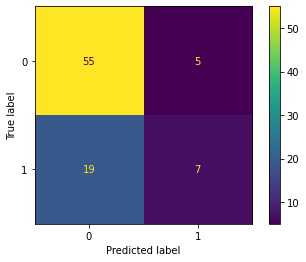

In [26]:
plot_confusion_matrix(CV_rfc, X_test, y_test)  
plt.show();

In [27]:
y_pred = CV_rfc.predict(X_test)

print('recall = ', recall_score(y_test, y_pred))
print('accuracy = ', accuracy_score(y_test, y_pred))

recall =  0.2692307692307692
accuracy =  0.7209302325581395


This approach alone **doesn't yield satisfying results**. Although the accuracy is relatively good (according to many publications, for example [this one](https://www.academia.edu/5149415/The_Multi_Purpose_Incremental_Learning_System_AQ15_and_Its_Testing_Application_to_Three_Medical_Domains)), **more than 50% of patient with breast cancer still wouldn't be diagnosed**.
<br>
One of the possible ways of increasing recall is to **search for a best discrimination threshold**.

In [28]:
y_probs = CV_rfc.predict_proba(X_test)[:, 1] # probabilities that recurrence events will occur

In [29]:
p, r, thresholds = precision_recall_curve(y_test, y_probs)

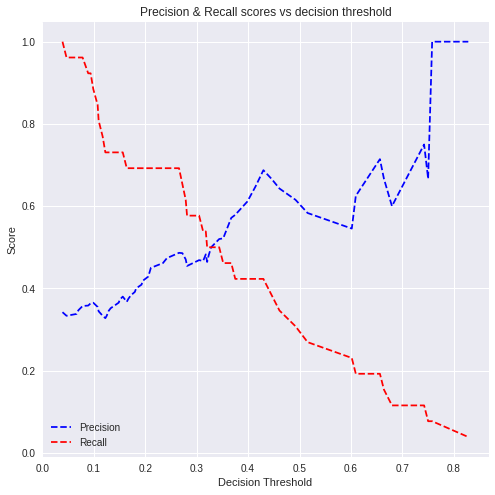

In [30]:
plt.style.use('seaborn')
plt.figure(figsize = (8, 8))
plt.title('Precision & Recall scores vs decision threshold')

plt.plot(thresholds, p[:-1], 'b--', label = 'Precision')
plt.plot(thresholds, r[:-1], 'r--', label = 'Recall')
         
plt.ylabel('Score')
plt.xlabel('Decision Threshold')
plt.legend();

<font color = 'gray'> This is a modified version of the plot from [this article](https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65). </font>

As expected, decreasing the decision threshold increases recall score. <br>

In [31]:
# determine best threshold
rec_ind = np.where(r == 1.)[0][-1] # the biggest index where recall = 1
best_thr = thresholds[rec_ind]
print(f'Best threshold: {best_thr}')

y_pred = CV_rfc.predict_proba(X_test)[:, 1]
y_pred = (y_pred >= best_thr) * 1

# final scores
print('recall = ', recall_score(y_test, y_pred))
print('accuracy = ', accuracy_score(y_test, y_pred))

Best threshold: 0.0390625
recall =  1.0
accuracy =  0.4186046511627907


**Note that returning 1 for each patient has a recall = 1.0 and accuracy = 0.297 only!**

## Summary

I've built a model for predicting if recurrence events will occur. <br>
Model's recall is 1.0 which means that there is a great chance every potentially endangered patient will be treated. <br>
Model's accuracy is low, but please keep in mind that this dataset "*is not sufficient to completely discriminate between cases*" ([source](https://www.academia.edu/5149415/The_Multi_Purpose_Incremental_Learning_System_AQ15_and_Its_Testing_Application_to_Three_Medical_Domains)). Originally, specialists' accuracy was 64% only. <br>